In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datosFull = np.loadtxt('data_to_fit.txt')
X = datosFull[:,0]
Y = datosFull[:,1]
SigmaY = datosFull[:,2]

In [3]:
def model_A(x,params):
    y = params[0] + params[1]*x + params[2]*x**2
    return y

def model_B(x,params):
    y = params[0]*np.exp(-0.5*(x-params[1])**2/params[2]**2)
    return y

def model_C(x,params):
    y = params[0]*np.exp(-0.5*(x-params[1])**2/params[2]**2)
    y += params[0]*np.exp(-0.5*(x-params[3])**2/params[4]**2)
    return y

In [4]:
def log_prior(w,modelo):
    if(modelo==model_B):
        return np.log(1*(w[2]>0))
    if(modelo==model_C):
        return np.log(1*(w[2]>0)*(w[4]>0))
    return 0

def log_verosimilitud_modelo(betas,X,Y,Sigma,modelo):
    delta = modelo(X,betas) - Y
    chi2 = (delta/Sigma)**2
    return np.sum(-chi2/2)

In [5]:
def MCMC(X,Y,Sigma,num_coefs,N,modelo):
    betas = [np.zeros(num_coefs)]
    log_likely = [log_verosimilitud_modelo(betas[0],X,Y,Sigma,modelo)]
    for i in range(0,N):
        paso = np.random.normal(loc=0.0,scale=0.02,size=len(betas[i]))
        nuevos_betas = betas[i]+paso
        log_nuevo = log_verosimilitud_modelo(nuevos_betas,X,Y,Sigma,modelo) + log_prior(nuevos_betas,modelo)
        log_viejo = log_verosimilitud_modelo(betas[i],X,Y,Sigma,modelo) + log_prior(betas[i],modelo)
        r = min(0,log_nuevo-log_viejo)
        alfa = np.random.rand()
        if np.exp(r)>=alfa:
            betas.append(nuevos_betas)
            log_likely.append(log_nuevo)
        else:
            betas.append(betas[i])
            log_likely.append(log_viejo)
    return np.array(betas[int(N/2):]),np.array(log_likely[int(N/2):])

def BIC(L,k,n):
    return -L + k/2 * np.log(n)

In [6]:
betasC,logsC = MCMC(X,Y,SigmaY,5,40000,model_C)
betasB,logsB = MCMC(X,Y,SigmaY,3,40000,model_B)
betasA,logsA = MCMC(X,Y,SigmaY,3,300000,model_A)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package 

In [7]:
Esti_BetasC = np.mean(betasC,axis=0)
Esti_BetasB = np.mean(betasB,axis=0)
Esti_BetasA = np.mean(betasA,axis=0)

desvC = np.std(betasC,axis=0)
desvB = np.std(betasB,axis=0)
desvA = np.std(betasA,axis=0)

BIC_C = BIC(np.amax(logsC),len(Esti_BetasC),len(X))
BIC_B = BIC(np.amax(logsB),len(Esti_BetasB),len(X))
BIC_A = BIC(np.amax(logsA),len(Esti_BetasA),len(X))

print(BIC(np.amax(logsC),len(Esti_BetasC),len(X)))
print(BIC(np.amax(logsB),len(Esti_BetasB),len(X)))
print(BIC(np.amax(logsA),len(Esti_BetasA),len(X)))

29.55635166339755
26.149091662796476
85.62742895447509


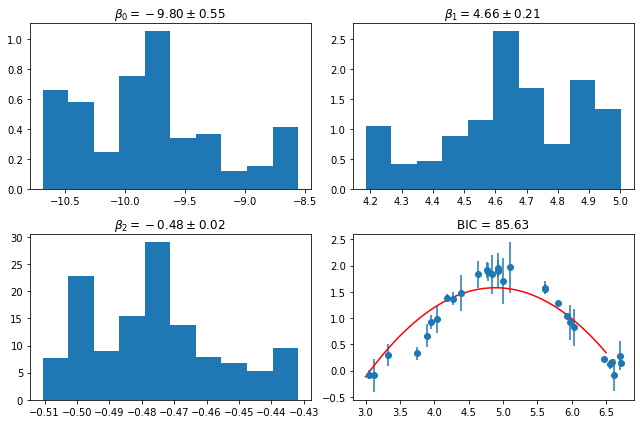

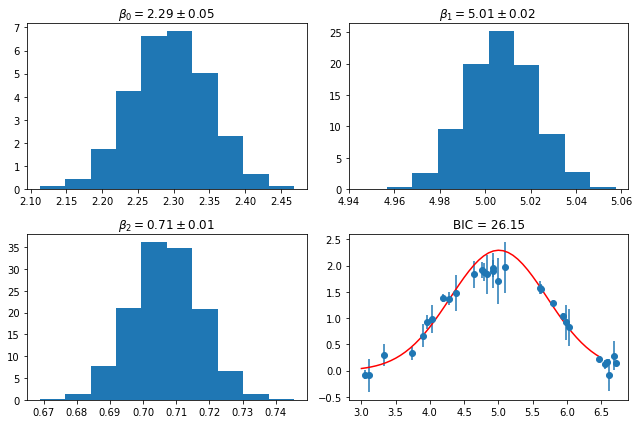

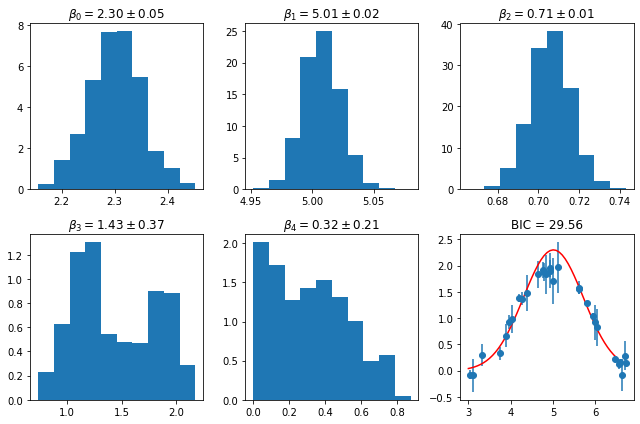

In [8]:
x_test = np.linspace(3,6.5)

# Modelo A -----------------------------------------------------------------
fig,axii = plt.subplots(2,2,figsize=(9,6))
axes = list(axii[0])+list(axii[1])

for i in range(0,len(Esti_BetasA)):
    axes[i].hist(betasA[:,i],density=True)
    axes[i].set_title(r'$\beta_{} = {:.2f} \pm {:.2f}$ '.format(i,Esti_BetasA[i],desvA[i]))
    
axes[3].plot(x_test,model_A(x_test,Esti_BetasA),c='r')
axes[3].errorbar(X, Y, yerr=SigmaY, fmt='o')
axes[3].set_title('BIC = {:.2f}'.format(BIC_A))

fig.tight_layout()
plt.savefig('modelo_A.png')

# Modelo B ------------------------------------------------------------
fig,axii = plt.subplots(2,2,figsize=(9,6))
axes = list(axii[0])+list(axii[1])

for i in range(0,len(Esti_BetasB)):
    axes[i].hist(betasB[:,i],density=True)
    axes[i].set_title(r'$\beta_{} = {:.2f} \pm {:.2f}$ '.format(i,Esti_BetasB[i],desvB[i]))
    
axes[3].plot(x_test,model_B(x_test,Esti_BetasB),c='r')
axes[3].errorbar(X, Y, yerr=SigmaY, fmt='o')
axes[3].set_title('BIC = {:.2f}'.format(BIC_B))

fig.tight_layout()
plt.savefig('modelo_B.png')

# Modelo C ------------------------------------------------------------
fig,axii = plt.subplots(2,3,figsize=(9,6))
axes = list(axii[0])+list(axii[1])

for i in range(0,len(Esti_BetasC)):
    axes[i].hist(betasC[:,i],density=True)
    axes[i].set_title(r'$\beta_{} = {:.2f} \pm {:.2f}$ '.format(i,Esti_BetasC[i],desvC[i]))
    
axes[5].plot(x_test,model_C(x_test,Esti_BetasC),c='r')
axes[5].errorbar(X, Y, yerr=SigmaY, fmt='o')
axes[5].set_title('BIC = {:.2f}'.format(BIC_C))

fig.tight_layout()
plt.savefig('modelo_C.png')

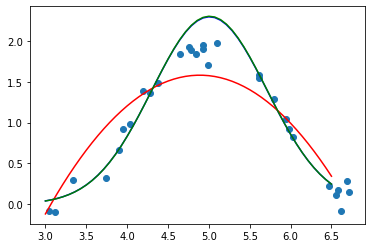

In [9]:
x_test = np.linspace(3,6.5)
plt.figure()
plt.scatter(X,Y)
plt.plot(x_test,model_B(x_test,Esti_BetasB),c='b')
plt.plot(x_test,model_A(x_test,Esti_BetasA),c='r')
plt.plot(x_test,model_C(x_test,Esti_BetasC),c='g')

ValueError: operands could not be broadcast together with shapes (30,) (3,) 